In [3]:
# Jupyter magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

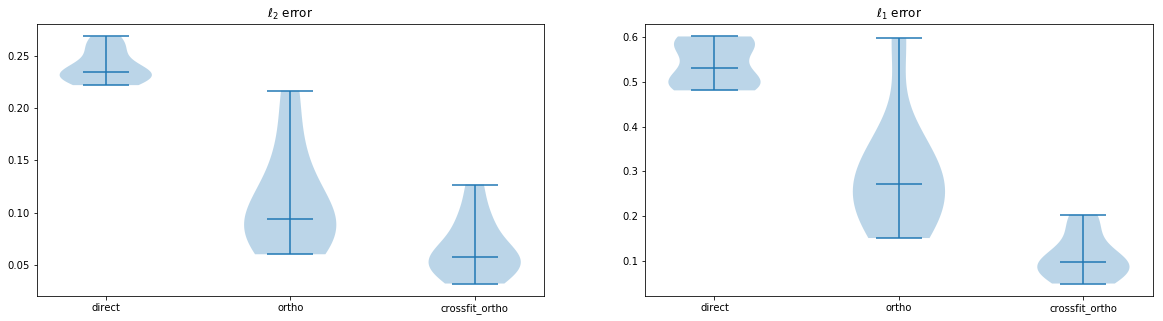

In [2]:
import numpy as np
from sklearn.linear_model import Lasso, MultiTaskLasso, MultiTaskLassoCV, LinearRegression
import matplotlib.pyplot as plt
from linear_te import gen_data, dml_fit, dml_crossfit

def main():
    n_samples = 2000 # samples used for estimation
    dim_x = 200 # dimension of controls x
    dim_z = 200 # dimension of variables used for heterogeneity (subset of x)
    kappa_x = 5 # support size of control function
    kappa_theta = 2 # support size of target parameter
    sigma_eta = 1 # variance of error in secondary moment equation
    sigma_epsilon = 1 # variance of error in primary moment equation
    lambda_coef = 1 # coeficient in front of the asymptotic rate for regularization lambda

    l2_direct = []
    l2_ortho = []
    l2_cross_ortho = []
    l1_direct = []
    l1_ortho = []
    l1_cross_ortho = []
    for _ in range(10):
        # Generate data
        x, t, z, y, support_x, support_theta, alpha_x, beta_x, theta =\
                gen_data(n_samples, dim_x, dim_z, kappa_x, kappa_theta, sigma_eta, sigma_epsilon)

        true_coef = np.zeros((dim_z,1))
        true_coef[support_theta] = theta

        # Direct lasso for all coefficients
        ols = Lasso(alpha=np.sqrt(np.log(dim_z + dim_x)/n_samples))
        ols.fit(np.concatenate((z*t, x), axis=1), y.flatten())
        l1_direct.append(np.linalg.norm(ols.coef_.flatten()[:dim_z] - true_coef.flatten(), ord=1))
        l2_direct.append(np.linalg.norm(ols.coef_.flatten()[:dim_z] - true_coef.flatten(), ord=2))
        
        # Orthogonal lasso estimation
        ortho_coef, t_coef, y_coef = dml_fit(x, t, z, y,\
                                        Lasso(alpha=lambda_coef * np.sqrt(np.log(dim_x)*2. / n_samples)),\
                                        Lasso(alpha=lambda_coef * np.sqrt(np.log(dim_z*dim_x)*2. / n_samples)),\
                                        Lasso(alpha=lambda_coef * np.sqrt(np.log(dim_z)*2. / n_samples), fit_intercept=False))
        l1_ortho.append(np.linalg.norm(ortho_coef - true_coef.flatten(), ord=1))
        l2_ortho.append(np.linalg.norm(ortho_coef - true_coef.flatten(), ord=2))
        
        # Crossfit Orthogonal lasso estimation
        ortho_coef, t_coef, y_coef = dml_crossfit(x, t, z, y,\
                                        Lasso(alpha=lambda_coef * np.sqrt(np.log(dim_x)*2. / n_samples)),\
                                        Lasso(alpha=lambda_coef * np.sqrt(np.log(dim_z*dim_x)*2. / n_samples)),\
                                        Lasso(alpha=lambda_coef * np.sqrt(np.log(dim_z)*2. / n_samples), fit_intercept=False))
        l1_cross_ortho.append(np.linalg.norm(ortho_coef - true_coef.flatten(), ord=1))
        l2_cross_ortho.append(np.linalg.norm(ortho_coef - true_coef.flatten(), ord=2))


    plt.figure(figsize=(20, 5))
    plt.subplot(1,2,1)
    plt.violinplot([np.array(l2_direct), np.array(l2_ortho), np.array(l2_cross_ortho)], showmedians=True)
    plt.xticks([1,2,3], ['direct', 'ortho', 'crossfit_ortho'])
    plt.title('$\ell_2$ error')
    plt.subplot(1,2,2)
    plt.violinplot([np.array(l1_direct), np.array(l1_ortho), np.array(l1_cross_ortho)], showmedians=True)
    plt.xticks([1,2,3], ['direct', 'ortho', 'crossfit_ortho'])
    plt.title('$\ell_1$ error')
    plt.show()
    
main()